In [50]:
# ==============================
# Importing all required libraries
# ==============================
import sys
import os
import warnings
warnings.filterwarnings("ignore")

# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn components
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report, RocCurveDisplay,
                             PrecisionRecallDisplay, roc_auc_score)
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Advanced Models for Comparison
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Print versions for reproducibility
print(" Environment Setup:")
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

# Global settings for reproducibility
RANDOM_STATE = 42
PRIMARY_METRIC = "f1"
SEED = RANDOM_STATE

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports and setup completed successfully!\n")

 Environment Setup:
Python: 3.12.12
Pandas: 2.2.2
NumPy: 2.0.2
✅ All imports and setup completed successfully!



In [51]:
# ==============================
# DATA LOADING & INITIAL EXPLORATION
# ==============================

TRAIN_PATH = "dataset_A_training.csv"
TEST_PATH = "dataset_A_testing.csv"

print(" Loading datasets...")
try:
    train_data = pd.read_csv(TRAIN_PATH)
    test_data = pd.read_csv(TEST_PATH)

    print("✅ Data loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please check the file paths and try again.")
    # If running in Colab, you might need to upload files first
    # from google.colab import files
    # uploaded = files.upload()

# Basic dataset information
print(f"\n Dataset Shapes:")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

print(f"\n Training Data Preview:")
display(train_data.head())

print(f"\n Training Data Info:")
train_data.info()

 Loading datasets...
✅ Data loaded successfully!

 Dataset Shapes:
Training data: (4756, 31)
Test data: (4749, 30)

 Training Data Preview:


,respondent_id,flu_concern,flu_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,employment_sector,seasonal_vaccine
0,1,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,Non-MSA,0.0,0.0,entertainment,0
1,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Male,NaN,Not Married,Rent,Employed,"MSA, Principle City",1.0,0.0,real_estate,0
2,3,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,Male,"> $75,000",Married,Own,Not in Labor Force,"MSA, Not Principle City",1.0,0.0,NaN,0
3,4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Male,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,2.0,utilities,1
4,5,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Not Principle City",2.0,0.0,NaN,0



 Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                4756 non-null   int64  
 1   flu_concern                  4744 non-null   float64
 2   flu_knowledge                4733 non-null   float64
 3   behavioral_antiviral_meds    4742 non-null   float64
 4   behavioral_avoidance         4724 non-null   float64
 5   behavioral_face_mask         4753 non-null   float64
 6   behavioral_wash_hands        4748 non-null   float64
 7   behavioral_large_gatherings  4747 non-null   float64
 8   behavioral_outside_home      4747 non-null   float64
 9   behavioral_touch_face        4737 non-null   float64
 10  doctor_recc_seasonal         4435 non-null   float64
 11  chronic_med_condition        4568 non-null   float64
 12  child_under_6_months         4604 non-null   float64
 

Target variable: seasonal_vaccine
ID column: respondent_id

 Feature Matrix Shape: (4756, 29)
Target Vector Shape: (4756,)

 Column Types:
Categorical features (10): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'employment_sector']
Numeric features (19): ['flu_concern', 'flu_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']

Target Distribution:


,Count,Percentage
seasonal_vaccine,,
1,2551,53.637511
0,2205,46.362489


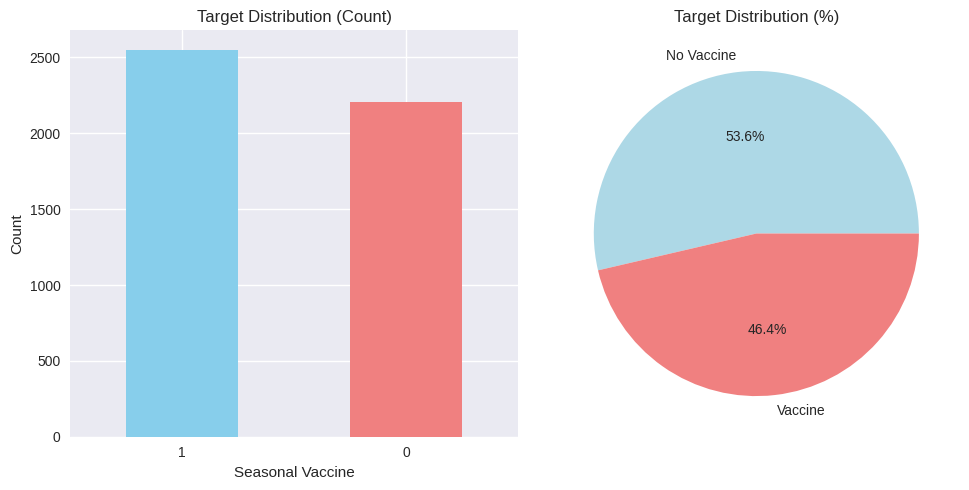

In [52]:
# ==============================
# DATA UNDERSTANDING & SETUP
# ==============================

# Define key columns
TARGET_COL = "seasonal_vaccine"
ID_COL = "respondent_id"

print(f"Target variable: {TARGET_COL}")
print(f"ID column: {ID_COL}")

# Verify required columns exist
assert TARGET_COL in train_data.columns, f"Target column '{TARGET_COL}' not found in training data!"
assert ID_COL in train_data.columns, f"ID column '{ID_COL}' not found in training data!"

# Prepare features and target
X = train_data.drop(columns=[TARGET_COL, ID_COL])  # Remove target and ID for modeling
y = train_data[TARGET_COL].astype(int)  # Ensure target is integer
X_test = test_data.drop(columns=[ID_COL])  # Remove ID from test data

print(f"\n Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

# Identify column types automatically
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n Column Types:")
print(f"Categorical features ({len(categorical_columns)}): {categorical_columns}")
print(f"Numeric features ({len(numeric_columns)}): {numeric_columns}")

# Check target distribution
print(f"\nTarget Distribution:")
target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_percentages
})
display(target_summary)

# Visualize target distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Distribution (Count)')
plt.xlabel('Seasonal Vaccine')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(target_counts, labels=['No Vaccine', 'Vaccine'], autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'])
plt.title('Target Distribution (%)')

plt.tight_layout()
plt.show()

 Starting Comprehensive EDA...

1. MISSING VALUES ANALYSIS
 Features with missing values in Training Data: 25


,Missing_Count,Missing_Percent
employment_sector,2314,48.654331
health_insurance,1925,40.475189
income_poverty,790,16.610597
rent_or_own,381,8.010934
doctor_recc_seasonal,321,6.749369
education,270,5.677040
employment_status,269,5.656013
marital_status,265,5.571909
chronic_med_condition,188,3.952902
child_under_6_months,152,3.195963


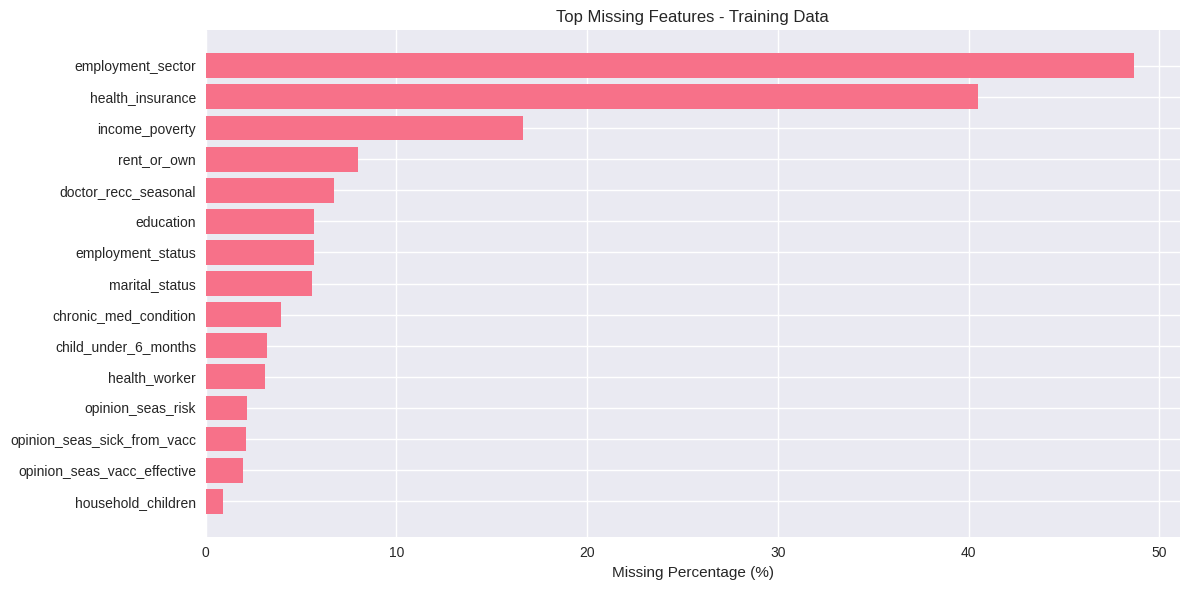

 Features with missing values in Test Data: 25


,Missing_Count,Missing_Percent
employment_sector,2405,50.642240
health_insurance,1982,41.735102
income_poverty,797,16.782481
rent_or_own,379,7.980628
doctor_recc_seasonal,345,7.264687
employment_status,277,5.832807
education,269,5.664350
marital_status,269,5.664350
chronic_med_condition,168,3.537587
child_under_6_months,155,3.263845


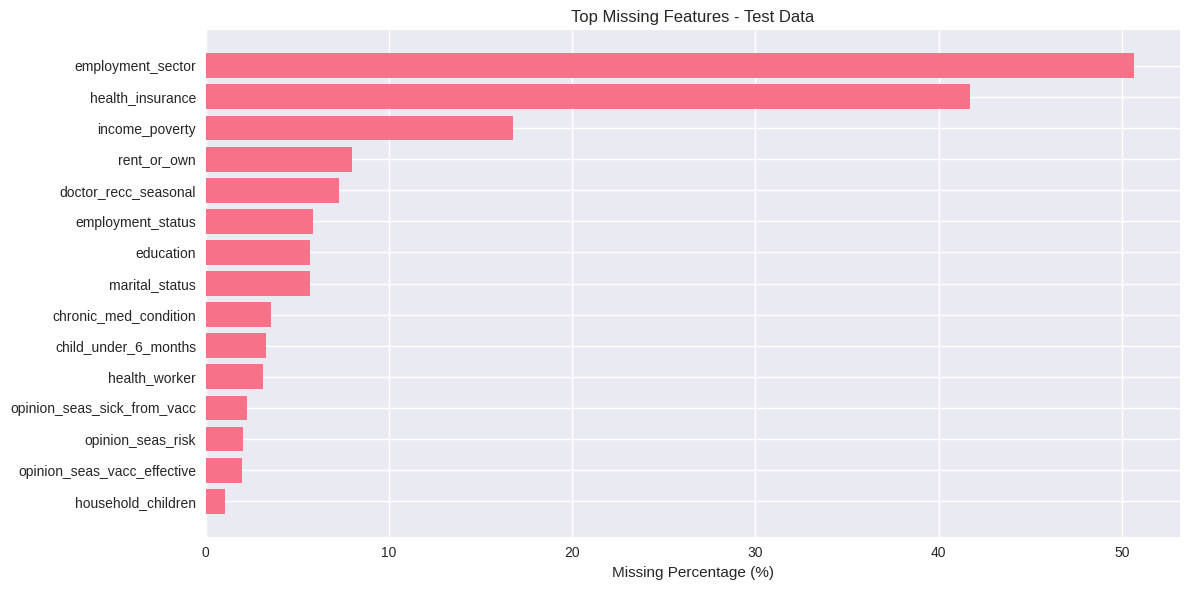

In [53]:
# ==============================
#  EXPLORATORY DATA ANALYSIS (EDA)
# ==============================

print(" Starting Comprehensive EDA...")

# 1. Missing Values Analysis
print("\n1. MISSING VALUES ANALYSIS")

def analyze_missing_data(data, dataset_name):
    """Analyze and visualize missing data patterns"""
    missing_stats = data.isnull().sum()
    missing_percent = (missing_stats / len(data)) * 100

    missing_df = pd.DataFrame({
        'Missing_Count': missing_stats,
        'Missing_Percent': missing_percent
    }).sort_values('Missing_Percent', ascending=False)

    # Display features with missing values
    missing_features = missing_df[missing_df['Missing_Count'] > 0]
    print(f" Features with missing values in {dataset_name}: {len(missing_features)}")

    if len(missing_features) > 0:
        display(missing_features.head(10))

        # Visualize top missing features
        plt.figure(figsize=(12, 6))
        top_missing = missing_features.head(15)
        plt.barh(top_missing.index, top_missing['Missing_Percent'])
        plt.xlabel('Missing Percentage (%)')
        plt.title(f'Top Missing Features - {dataset_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("✅ No missing values found!")

    return missing_df

# Analyze missing values in both datasets
train_missing = analyze_missing_data(train_data, "Training Data")
test_missing = analyze_missing_data(test_data, "Test Data")


2. NUMERICAL FEATURES ANALYSIS
 Analyzing 19 numerical features...
Statistical Summary:


,flu_concern,flu_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,4744.000000,4733.000000,4742.000000,4724.000000,4753.000000,4748.000000,4747.000000,4747.000000,4737.000000,4435.000000,4568.000000,4604.000000,4607.000000,2831.000000,4662.000000,4654.000000,4655.000000,4712.000000,4712.000000
mean,1.643128,1.293049,0.052299,0.734124,0.073848,0.836563,0.365494,0.336634,0.688410,0.373619,0.302102,0.091442,0.136965,0.889085,4.095024,2.876880,2.127390,0.895586,0.541596
std,0.919810,0.618902,0.222652,0.441846,0.261551,0.369803,0.481619,0.472608,0.463192,0.483819,0.459219,0.288268,0.343848,0.314082,1.076051,1.409834,1.337812,0.759658,0.936970
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,3.000000,3.000000


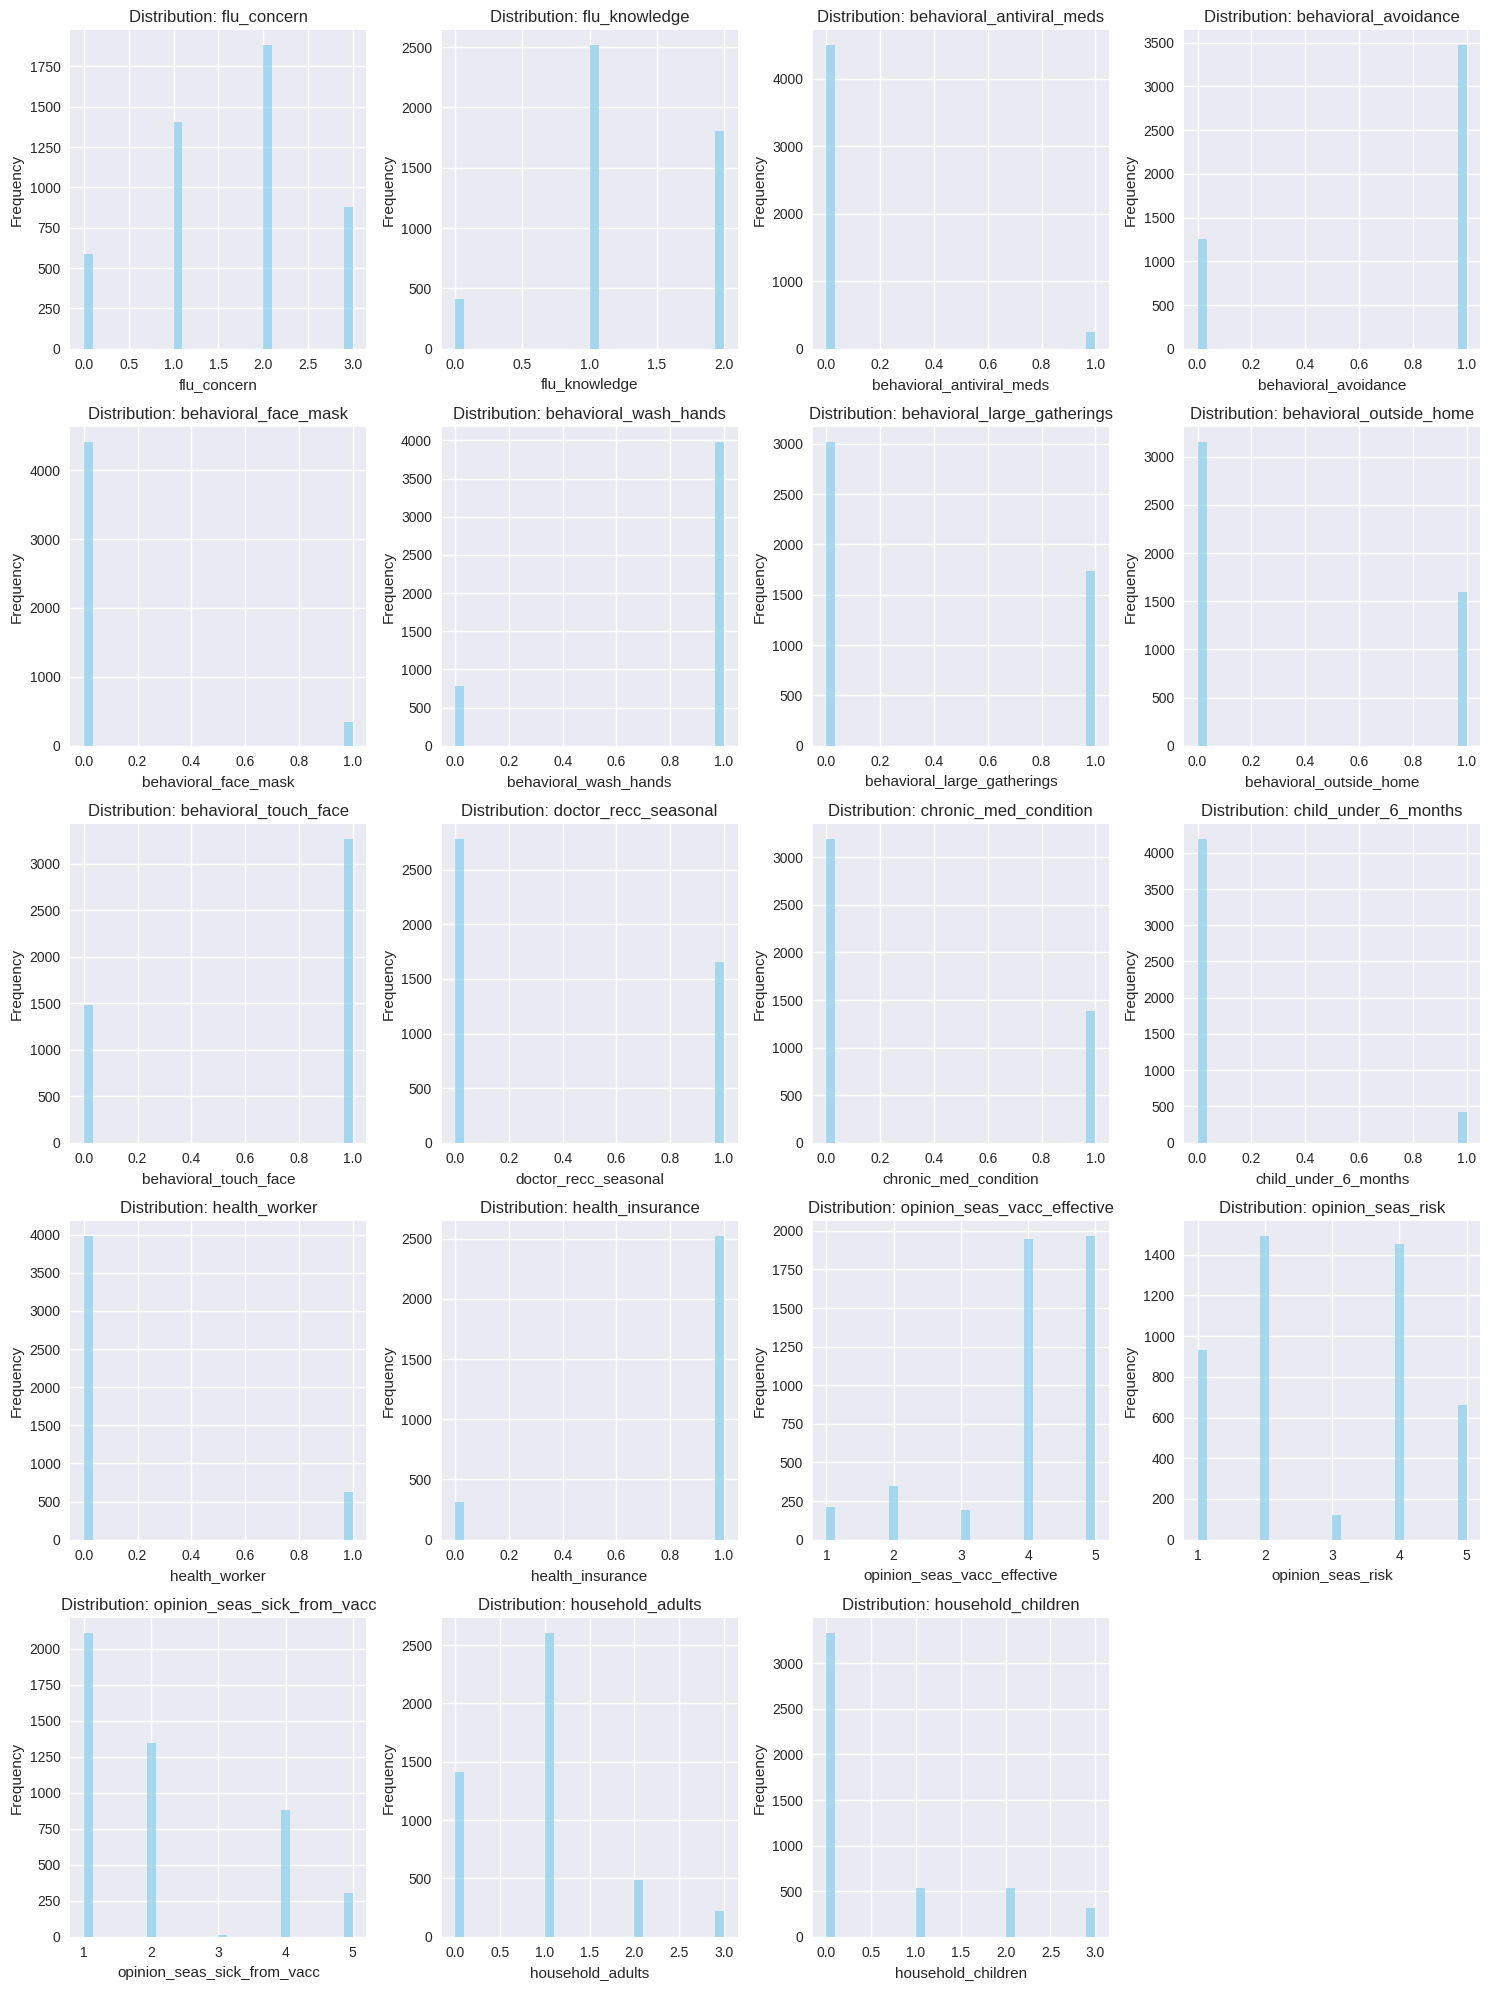

In [54]:
# 2. Numerical Features Analysis
print("\n2. NUMERICAL FEATURES ANALYSIS")

if len(numeric_columns) > 0:
    print(f" Analyzing {len(numeric_columns)} numerical features...")

    # Statistical summary
    print("Statistical Summary:")
    display(X[numeric_columns].describe())

    # Distribution plots
    n_cols = min(4, len(numeric_columns))
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for i, col in enumerate(numeric_columns):
        if i < len(axes):
            X[col].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue')
            axes[i].set_title(f'Distribution: {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')

    # Hide empty subplots
    for i in range(len(numeric_columns), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

else:
    print("❌ No numerical features found!")


3.CATEGORICAL FEATURES ANALYSIS
🏷️ Analyzing 10 categorical features...

📋 Feature: age_group
Unique values: 5
Top categories:


,count
age_group,
65+ Years,1169
55 - 64 Years,999
18 - 34 Years,960
45 - 54 Years,931
35 - 44 Years,697


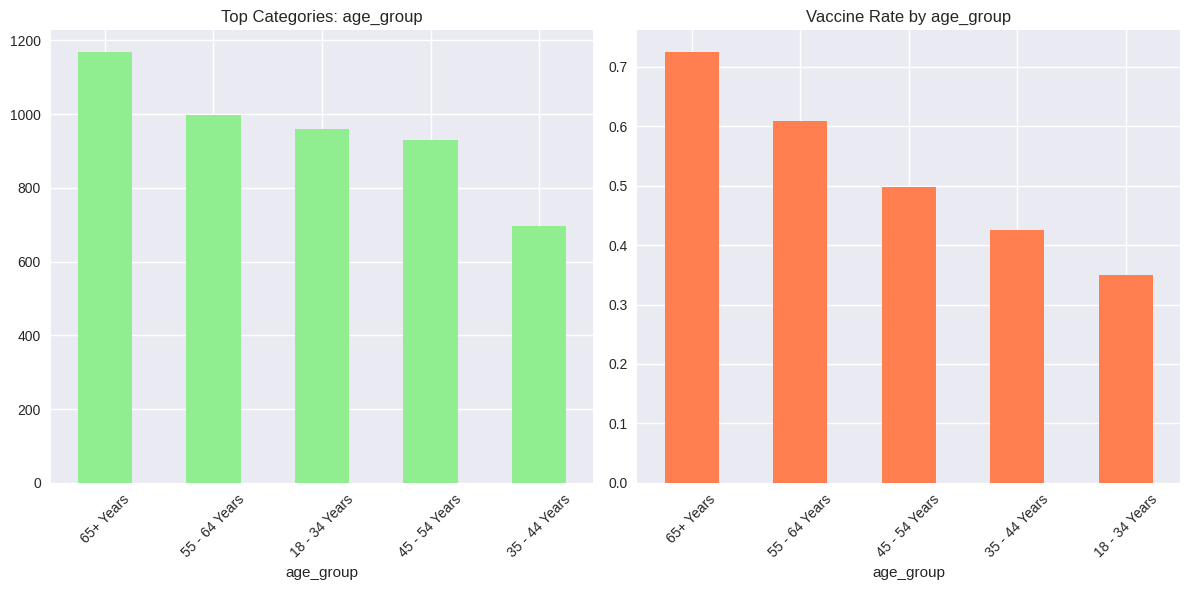


📋 Feature: education
Unique values: 4
Top categories:


,count
education,
College Graduate,1879
Some College,1209
12 Years,992
< 12 Years,406
NaN,270


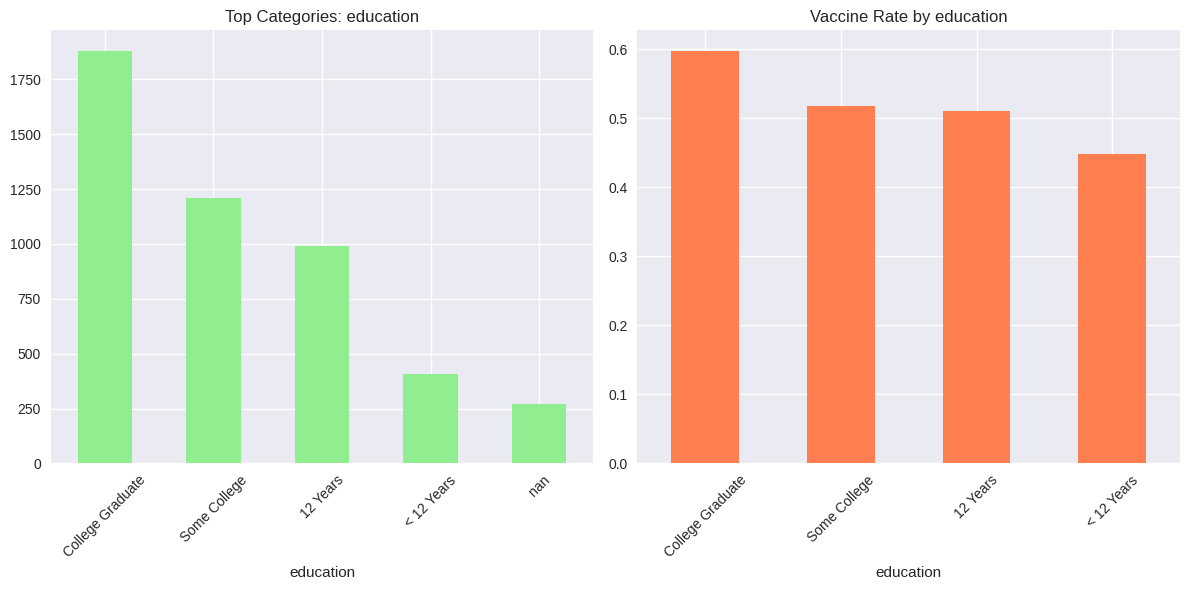


📋 Feature: race
Unique values: 4
Top categories:


,count
race,
White,3766
Black,362
Other or Multiple,317
Hispanic,311


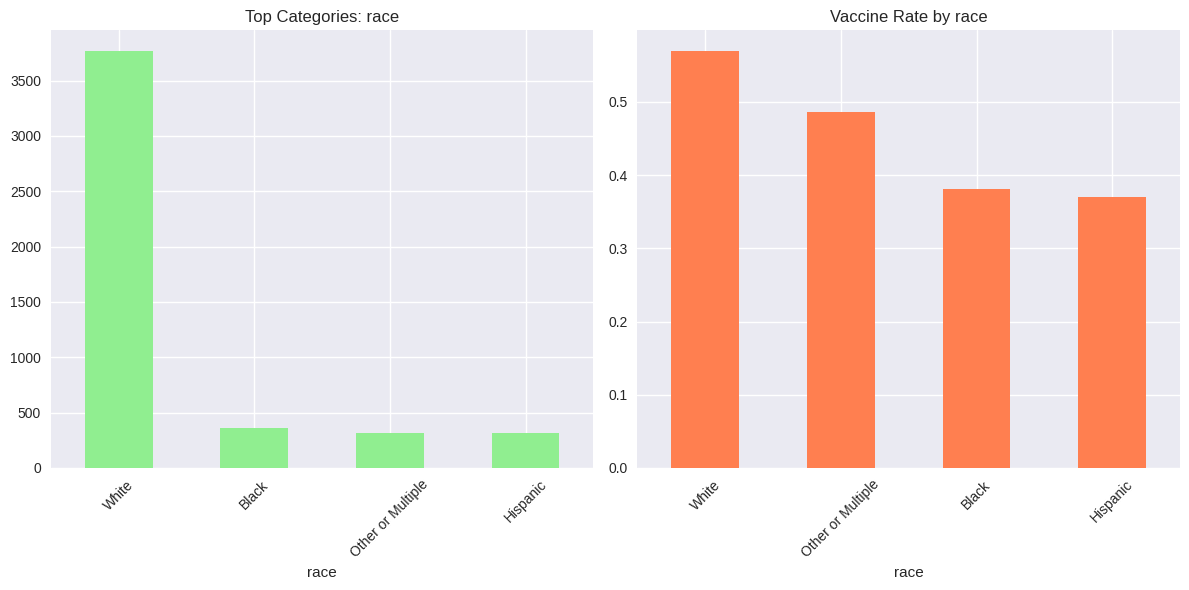


📋 Feature: sex
Unique values: 2
Top categories:


,count
sex,
Female,2783
Male,1973


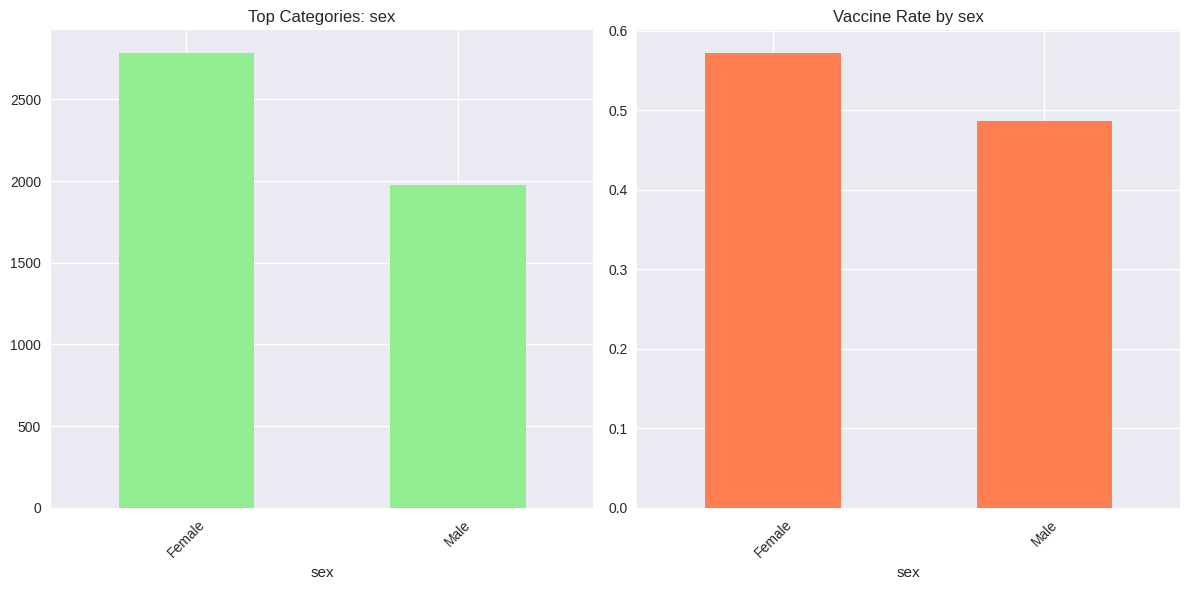


📋 Feature: income_poverty
Unique values: 3
Top categories:


,count
income_poverty,
"<= $75,000, Above Poverty",2258
"> $75,000",1250
NaN,790
Below Poverty,458


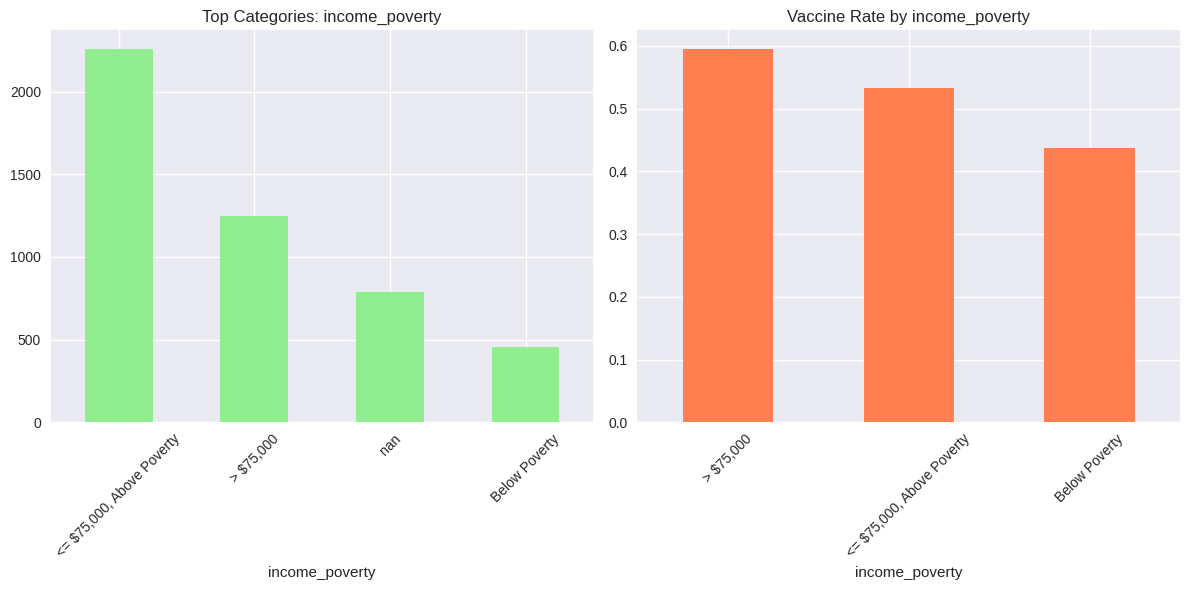


📋 Feature: marital_status
Unique values: 2
Top categories:


,count
marital_status,
Married,2403
Not Married,2088
NaN,265


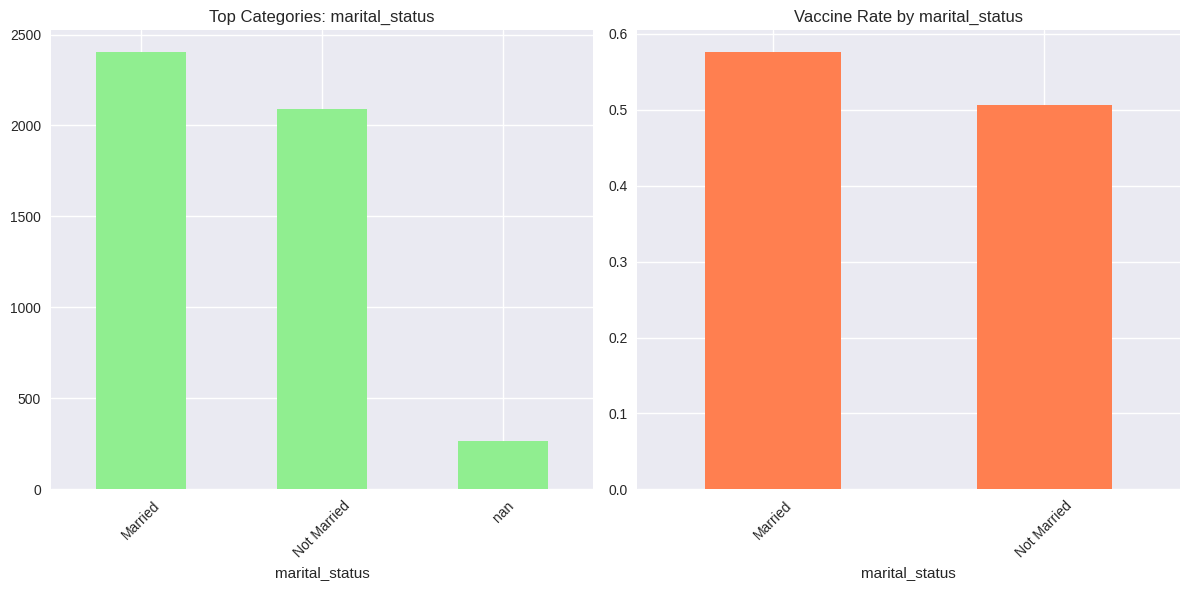


📋 Feature: rent_or_own
Unique values: 2
Top categories:


,count
rent_or_own,
Own,3292
Rent,1083
NaN,381


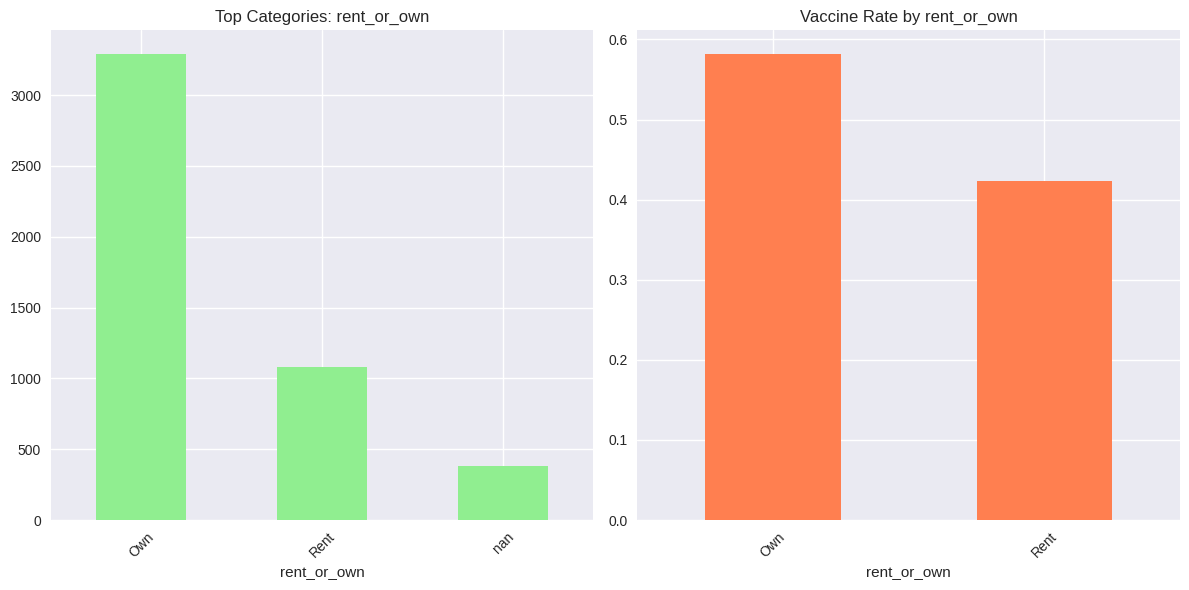


📋 Feature: employment_status
Unique values: 3
Top categories:


,count
employment_status,
Employed,2467
Not in Labor Force,1786
NaN,269
Unemployed,234


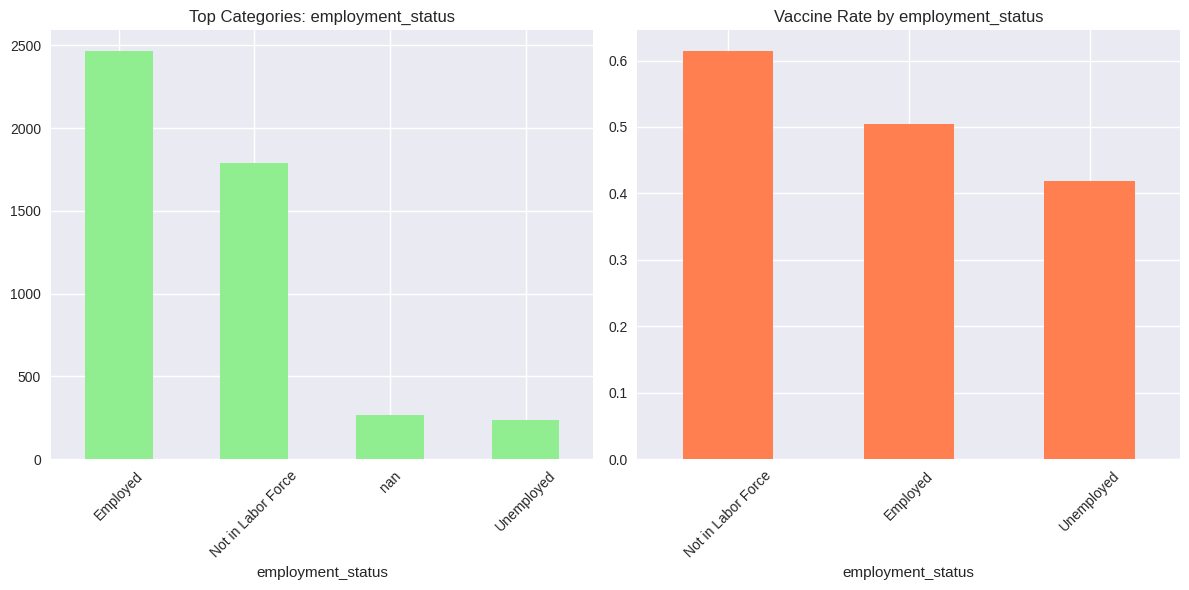


📋 Feature: census_msa
Unique values: 3
Top categories:


,count
census_msa,
"MSA, Not Principle City",2059
"MSA, Principle City",1418
Non-MSA,1279


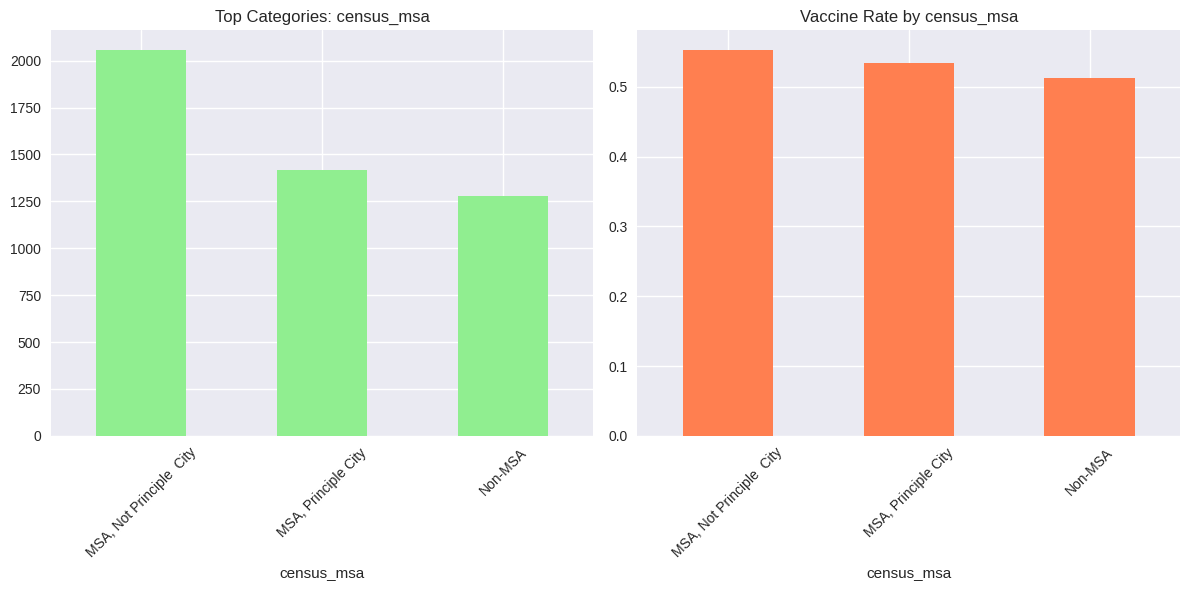


📋 Feature: employment_sector
Unique values: 21
Top categories:


,count
employment_sector,
NaN,2314
media,511
construction,355
wholesale,207
agriculture,176
real_estate,167
utilities,165
science,143
hospitality,116


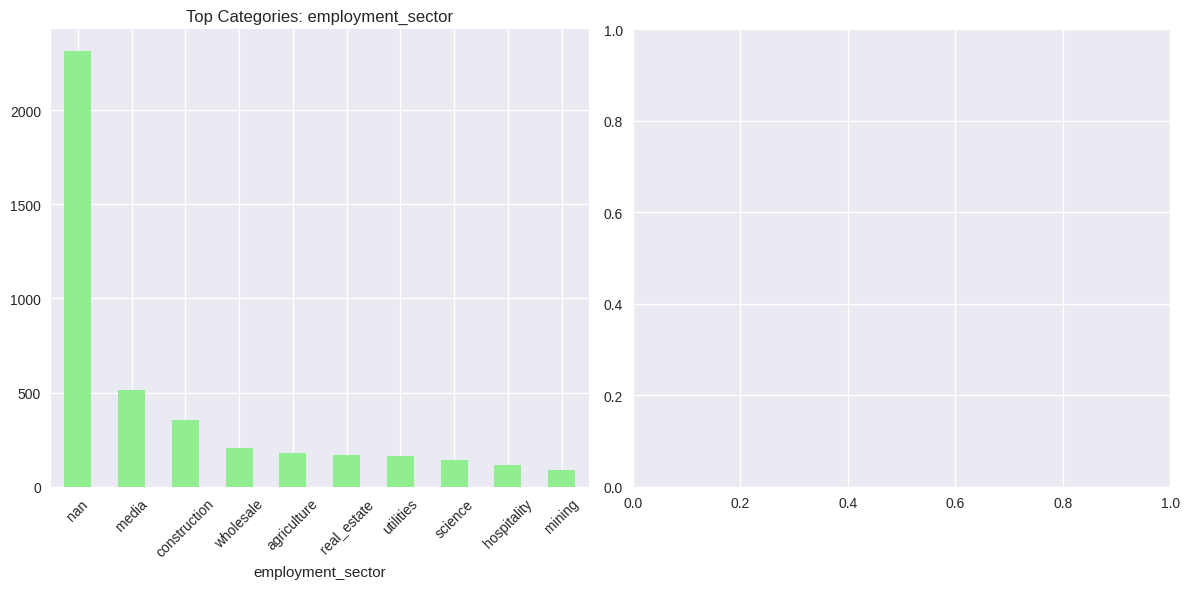

In [55]:
# 3. Categorical Features Analysis
print("\n3.CATEGORICAL FEATURES ANALYSIS")

if len(categorical_columns) > 0:
    print(f"🏷️ Analyzing {len(categorical_columns)} categorical features...")

    for col in categorical_columns:
        print(f"\n📋 Feature: {col}")
        value_counts = X[col].value_counts(dropna=False)

        print(f"Unique values: {X[col].nunique()}")
        print("Top categories:")
        display(value_counts.head(10))

        # Plot top categories
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        value_counts.head(10).plot(kind='bar', color='lightgreen')
        plt.title(f'Top Categories: {col}')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        # Target rate by category (if enough categories)
        if value_counts.shape[0] <= 15:
            target_rates = train_data.groupby(col)[TARGET_COL].mean().sort_values(ascending=False)
            target_rates.plot(kind='bar', color='coral')
            plt.title(f'Vaccine Rate by {col}')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

else:
    print("❌ No categorical features found!")


4.CORRELATION ANALYSIS


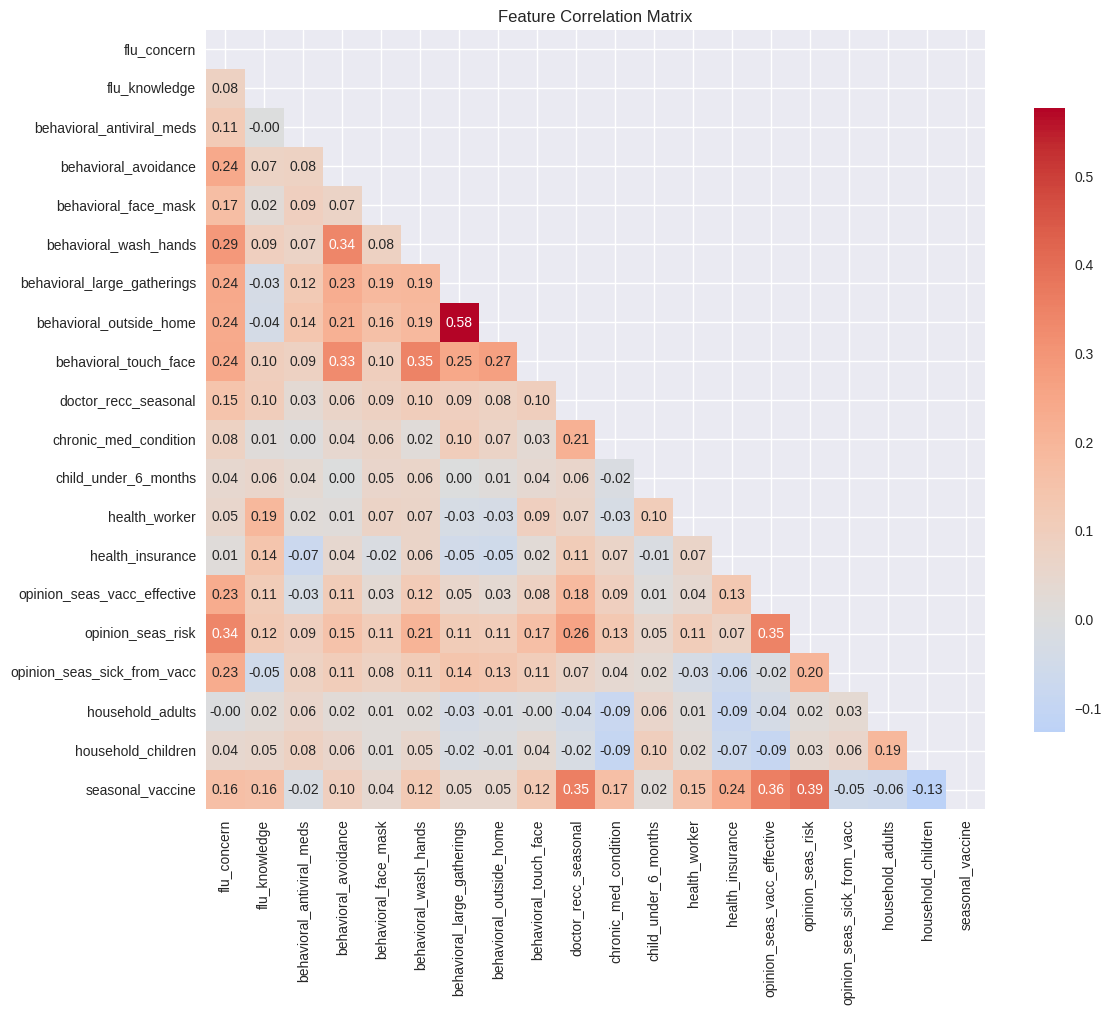

 Top correlations with target variable:


,seasonal_vaccine
seasonal_vaccine,1.000000
opinion_seas_risk,0.393312
opinion_seas_vacc_effective,0.357129
doctor_recc_seasonal,0.354831
health_insurance,0.235809
chronic_med_condition,0.166391
flu_concern,0.163732
flu_knowledge,0.155676
health_worker,0.149263
household_children,0.127039


In [56]:
# 4. Correlation Analysis
print("\n4.CORRELATION ANALYSIS")

# Numerical correlations
if len(numeric_columns) > 1:
    correlation_matrix = train_data[numeric_columns + [TARGET_COL]].corr(numeric_only=True)

    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle

    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Show top correlations with target
    target_correlations = correlation_matrix[TARGET_COL].abs().sort_values(ascending=False)
    print(" Top correlations with target variable:")
    display(target_correlations.head(10))


5.FEATURE IMPORTANCE ANALYSIS
Calculating Mutual Information scores...
Top 20 Features by Mutual Information:


,Feature,MI_Score
14,opinion_seas_vacc_effective,0.083835
15,opinion_seas_risk,0.071224
9,doctor_recc_seasonal,0.062413
17,age_group,0.039211
28,employment_sector,0.025313
13,health_insurance,0.017213
0,flu_concern,0.012657
12,health_worker,0.012047
1,flu_knowledge,0.011837
10,chronic_med_condition,0.011532


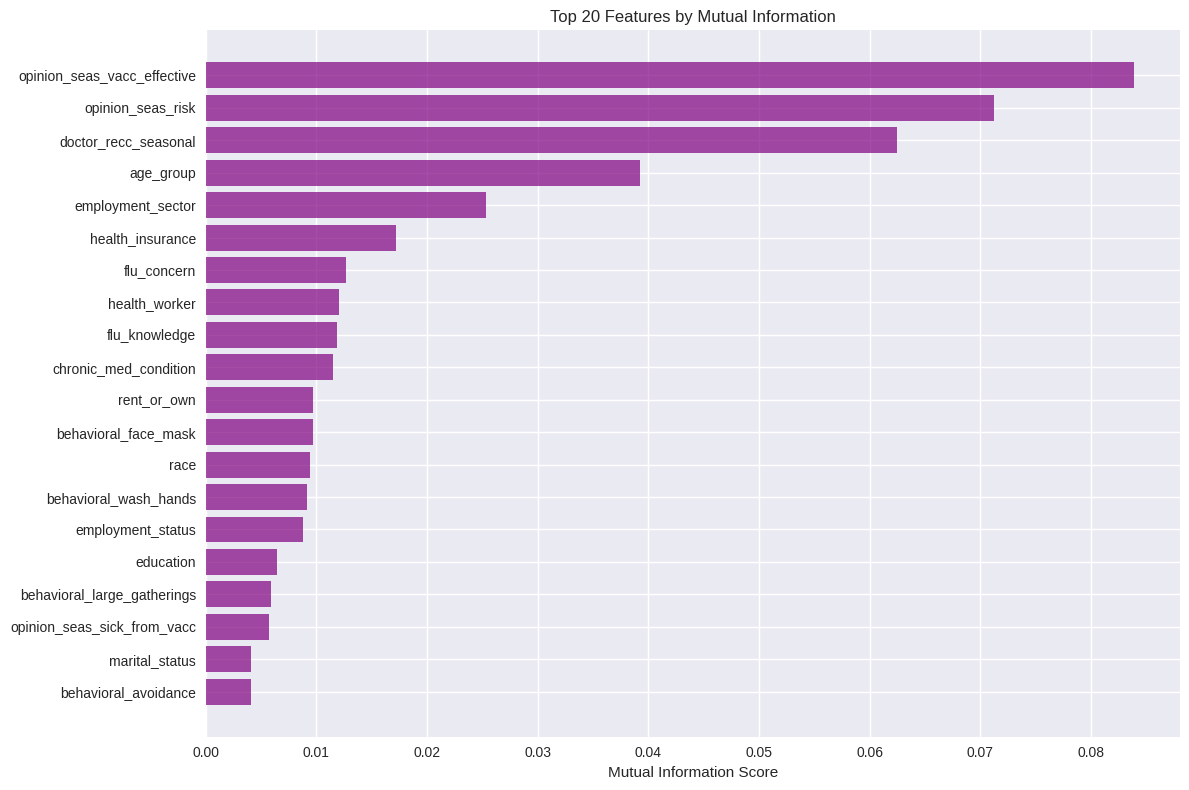

In [57]:
# 5. Feature Importance Analysis
print("\n5.FEATURE IMPORTANCE ANALYSIS")

# Mutual Information for feature relevance
print("Calculating Mutual Information scores...")

# Prepare data for MI calculation
X_mi = X.copy()

# Handle missing values temporarily
for col in numeric_columns:
    X_mi[col] = X_mi[col].fillna(X_mi[col].median())
for col in categorical_columns:
    X_mi[col] = X_mi[col].fillna("MISSING")

# Encode categorical variables for MI
for col in categorical_columns:
    freq_encoding = X_mi[col].value_counts().to_dict()
    X_mi[col] = X_mi[col].map(freq_encoding).fillna(0)

# Calculate Mutual Information
mi_scores = mutual_info_classif(X_mi, y,
                               discrete_features=[col in categorical_columns for col in X.columns],
                               random_state=SEED)

mi_results = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Top 20 Features by Mutual Information:")
display(mi_results.head(20))

# Visualize top MI scores
plt.figure(figsize=(12, 8))
top_mi = mi_results.head(20)
plt.barh(top_mi['Feature'], top_mi['MI_Score'], color='purple', alpha=0.7)
plt.xlabel('Mutual Information Score')
plt.title('Top 20 Features by Mutual Information')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [58]:
# ==============================
# DATA PREPROCESSING PIPELINES
# ==============================

print("Building preprocessing pipelines...")

# Strategy 1: For Tree-based models (no scaling needed)
numeric_tree_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_tree_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_tree = ColumnTransformer([
    ('numeric', numeric_tree_pipeline, numeric_columns),
    ('categorical', categorical_tree_pipeline, categorical_columns)
])

# Strategy 2: For Linear models (scaling needed)
numeric_linear_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_linear_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_linear = ColumnTransformer([
    ('numeric', numeric_linear_pipeline, numeric_columns),
    ('categorical', categorical_linear_pipeline, categorical_columns)
])

# Strategy 3: With feature binning (experimental)
numeric_binned_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='quantile'))
])

preprocessor_binned = ColumnTransformer([
    ('numeric_binned', numeric_binned_pipeline, numeric_columns),
    ('categorical', categorical_tree_pipeline, categorical_columns)
])

print("✅ Preprocessing pipelines created successfully!")
print(f"• Tree Preprocessor: {preprocessor_tree}")
print(f"• Linear Preprocessor: {preprocessor_linear}")
print(f"• Binned Preprocessor: {preprocessor_binned}")

Building preprocessing pipelines...
✅ Preprocessing pipelines created successfully!
• Tree Preprocessor: ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['flu_concern', 'flu_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face',
                                  'doctor_recc_seasonal',
                                  'chronic_med...
                                  'opinion_seas_sick_from_vacc',
                                  'househ

In [59]:
# ==============================
# MACHINE LEARNING MODEL SETUP
# ==============================

print("Setting up machine learning models for comparison...")

# Define our model candidates with different preprocessing strategies
model_candidates = {
    # 1. Logistic Regression (Linear model)
    "Logistic_Regression": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor_linear),
            ('model', LogisticRegression(random_state=SEED, max_iter=1000))
        ]),
        "param_grid": {
            'model__C': [0.1, 1.0, 10.0],
            'model__class_weight': [None, 'balanced']
        }
    },

    # 2. Random Forest (Ensemble tree-based)
    "Random_Forest": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('model', RandomForestClassifier(random_state=SEED, n_jobs=-1))
        ]),
        "param_grid": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },

    # 3. Gradient Boosting
    "Gradient_Boosting": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('model', GradientBoostingClassifier(random_state=SEED))
        ]),
        "param_grid": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 4]
        }
    },

    # 4. Histogram-Based Gradient Boosting (Fast!)
    "HistGradient_Boosting": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('model', HistGradientBoostingClassifier(random_state=SEED))
        ]),
        "param_grid": {
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [5, 10, 15],
            'model__l2_regularization': [0, 0.1]
        }
    },

    # 5. XGBoost
    "XGBoost": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('model', XGBClassifier(random_state=SEED, n_jobs=-1, eval_metric='logloss'))
        ]),
        "param_grid": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 6],
            'model__subsample': [0.8, 1.0]
        }
    },

    # 6. LightGBM (Very fast and effective)
    "LightGBM": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('model', LGBMClassifier(random_state=SEED, n_jobs=-1, verbose=-1))
        ]),
        "param_grid": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__num_leaves': [31, 63],
            'model__max_depth': [5, 10]
        }
    }
}

print(f"✅ {len(model_candidates)} models configured for comparison!")
print("Models to be evaluated:")
for model_name in model_candidates.keys():
    print(f"  • {model_name}")

Setting up machine learning models for comparison...
✅ 6 models configured for comparison!
Models to be evaluated:
  • Logistic_Regression
  • Random_Forest
  • Gradient_Boosting
  • HistGradient_Boosting
  • XGBoost
  • LightGBM


Starting model training and hyperparameter tuning...
Using 5-fold stratified cross-validation

MODEL TRAINING PROGRESS

Training: Logistic_Regression
----------------------------------------
✅ Best CV F1 Score: 0.7971
🔧 Best Parameters: {'model__C': 10.0, 'model__class_weight': None}

Training: Random_Forest
----------------------------------------
✅ Best CV F1 Score: 0.7890
🔧 Best Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}

Training: Gradient_Boosting
----------------------------------------
✅ Best CV F1 Score: 0.7961
🔧 Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200}

Training: HistGradient_Boosting
----------------------------------------
✅ Best CV F1 Score: 0.7927
🔧 Best Parameters: {'model__l2_regularization': 0.1, 'model__learning_rate': 0.05, 'model__max_depth': 10}

Training: XGBoost
----------------------------------------
✅ Best CV F1 Score: 0.7

,model,best_cv_score
0,Logistic_Regression,0.797136
1,XGBoost,0.796928
2,Gradient_Boosting,0.796120
3,LightGBM,0.794971
4,HistGradient_Boosting,0.792745
5,Random_Forest,0.788990


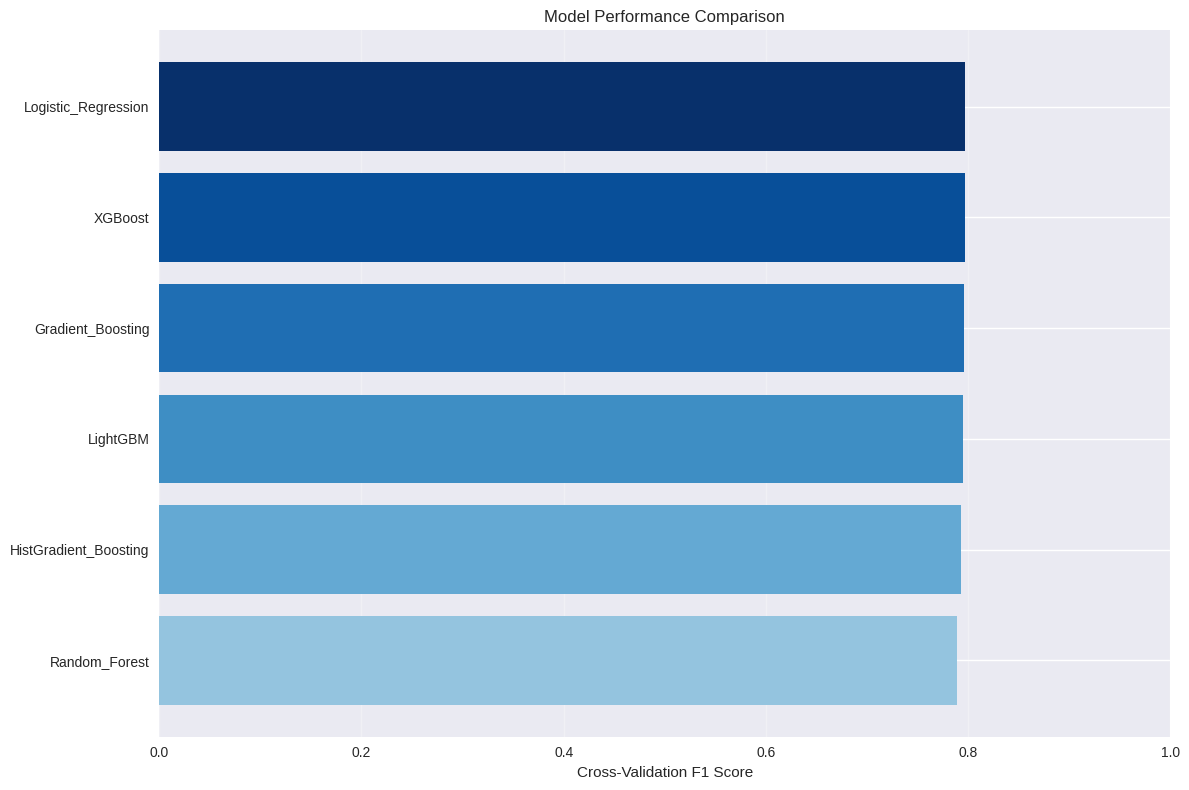


 BEST MODEL: Logistic_Regression
🏆 Best CV F1 Score: 0.7971


In [60]:
# ==============================
# MODEL TRAINING & HYPERPARAMETER TUNING
# ==============================

print("Starting model training and hyperparameter tuning...")

# Setup cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
print(f"Using {cv_strategy.n_splits}-fold stratified cross-validation")

# Store results
training_results = []
best_models = {}

print("\n" + "="*60)
print("MODEL TRAINING PROGRESS")
print("="*60)

for model_name, model_config in model_candidates.items():
    print(f"\nTraining: {model_name}")
    print("-" * 40)

    try:
        # Setup GridSearch with F1 scoring
        grid_search = GridSearchCV(
            estimator=model_config["pipeline"],
            param_grid=model_config["param_grid"],
            scoring=PRIMARY_METRIC,
            cv=cv_strategy,
            n_jobs=-1,
            verbose=0
        )

        # Train model with hyperparameter tuning
        grid_search.fit(X, y)

        # Store results
        best_models[model_name] = grid_search.best_estimator_

        result = {
            "model": model_name,
            "best_cv_score": grid_search.best_score_,
            "best_params": grid_search.best_params_,
            "best_estimator": grid_search.best_estimator_
        }
        training_results.append(result)

        print(f"✅ Best CV F1 Score: {grid_search.best_score_:.4f}")
        print(f"🔧 Best Parameters: {grid_search.best_params_}")

    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        continue

print("\n" + "="*60)
print("TRAINING COMPLETED - RESULTS SUMMARY")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame(training_results)
results_df = results_df.sort_values("best_cv_score", ascending=False).reset_index(drop=True)

# Display results
print("\n📊 Model Performance Ranking (by CV F1 Score):")
display(results_df[["model", "best_cv_score"]].style.background_gradient(cmap='Blues'))

# Visualize model comparison
plt.figure(figsize=(12, 8))
models_ranked = results_df.sort_values("best_cv_score", ascending=True)
plt.barh(models_ranked["model"], models_ranked["best_cv_score"],
         color=plt.cm.Blues(np.linspace(0.4, 1, len(models_ranked))))
plt.xlabel('Cross-Validation F1 Score')
plt.title('Model Performance Comparison')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Identify best model
best_model_name = results_df.iloc[0]["model"]
best_model = best_models[best_model_name]
print(f"\n BEST MODEL: {best_model_name}")
print(f"🏆 Best CV F1 Score: {results_df.iloc[0]['best_cv_score']:.4f}")

Analyzing best model performance in detail...
🔍 Detailed analysis for: Logistic_Regression

1.Out-of-Fold Performance Analysis
🎯 F1 Score: 0.7971
🎯 Precision: 0.7911
🎯 Recall: 0.8032
🎯 Accuracy: 0.7807
📊 AUC-ROC: 0.8467

2. 🎯 Confusion Matrix


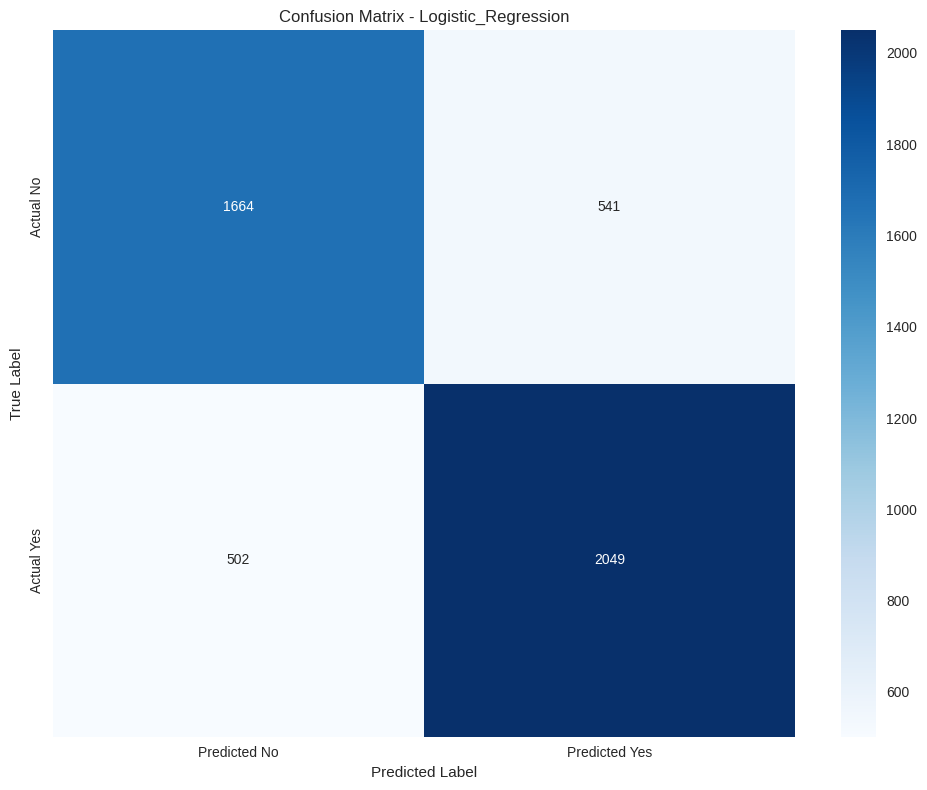


3. 📈 ROC Curve


<Figure size 1000x600 with 0 Axes>

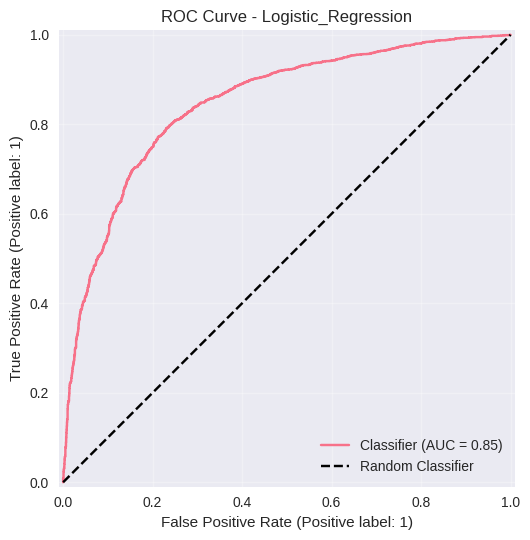


4. 📊 Precision-Recall Curve


<Figure size 1000x600 with 0 Axes>

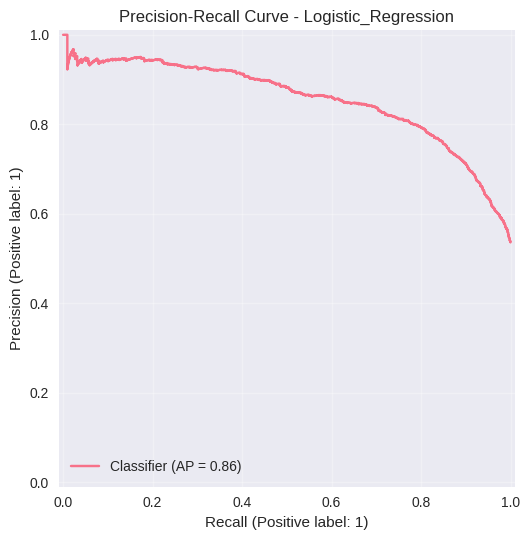

In [61]:
# ==============================
# 📊 MODEL PERFORMANCE ANALYSIS
# ==============================

print("Analyzing best model performance in detail...")

# Get the best model
best_model_name = results_df.iloc[0]["model"]
best_model = best_models[best_model_name]

print(f"🔍 Detailed analysis for: {best_model_name}")

# 1. Out-of-Fold Predictions for robust evaluation
print("\n1.Out-of-Fold Performance Analysis")
oof_predictions_proba = cross_val_predict(best_model, X, y, cv=cv_strategy,
                                         method='predict_proba', n_jobs=-1)
oof_predictions = (oof_predictions_proba[:, 1] >= 0.5).astype(int)

# Calculate metrics
f1 = f1_score(y, oof_predictions)
precision = precision_score(y, oof_predictions)
recall = recall_score(y, oof_predictions)
accuracy = accuracy_score(y, oof_predictions)
auc_roc = roc_auc_score(y, oof_predictions_proba[:, 1])

print(f"🎯 F1 Score: {f1:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall: {recall:.4f}")
print(f"🎯 Accuracy: {accuracy:.4f}")
print(f"📊 AUC-ROC: {auc_roc:.4f}")

# 2. Confusion Matrix
print("\n2. 🎯 Confusion Matrix")
cm = confusion_matrix(y, oof_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 3. ROC Curve
print("\n3. 📈 ROC Curve")
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_predictions(y, oof_predictions_proba[:, 1])
plt.title(f'ROC Curve - {best_model_name}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Precision-Recall Curve
print("\n4. 📊 Precision-Recall Curve")
plt.figure(figsize=(10, 6))
PrecisionRecallDisplay.from_predictions(y, oof_predictions_proba[:, 1])
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


5.Threshold Tuning Analysis
🎯 Optimal threshold: 0.443
🎯 Best F1 score at this threshold: 0.8013


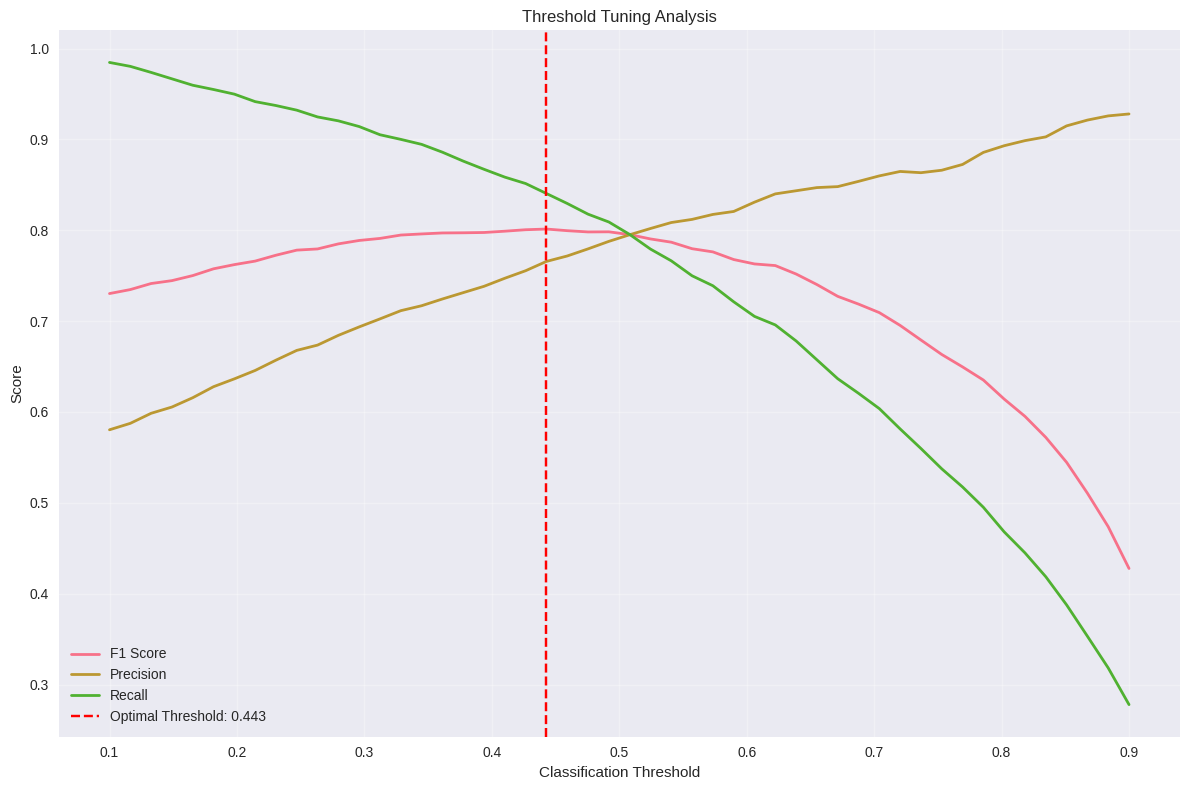


📊 Top 5 thresholds by F1 score:


,threshold,f1_score,precision,recall
21,0.442857,0.801346,0.765714,0.840455
20,0.426531,0.800590,0.755478,0.851431
22,0.459184,0.799547,0.771699,0.829479
19,0.410204,0.798978,0.747185,0.858487
24,0.491837,0.798298,0.787786,0.809094


In [62]:
# 5. Threshold Tuning Analysis
print("\n5.Threshold Tuning Analysis")

# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 50)
threshold_results = []

for threshold in thresholds:
    predictions = (oof_predictions_proba[:, 1] >= threshold).astype(int)
    f1 = f1_score(y, predictions)
    precision_val = precision_score(y, predictions)
    recall_val = recall_score(y, predictions)

    threshold_results.append({
        'threshold': threshold,
        'f1_score': f1,
        'precision': precision_val,
        'recall': recall_val
    })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold
optimal_threshold = threshold_df.loc[threshold_df['f1_score'].idxmax()]
print(f"🎯 Optimal threshold: {optimal_threshold['threshold']:.3f}")
print(f"🎯 Best F1 score at this threshold: {optimal_threshold['f1_score']:.4f}")

# Plot threshold analysis
plt.figure(figsize=(12, 8))
plt.plot(threshold_df['threshold'], threshold_df['f1_score'], label='F1 Score', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', linewidth=2)

plt.axvline(optimal_threshold['threshold'], color='red', linestyle='--',
            label=f'Optimal Threshold: {optimal_threshold["threshold"]:.3f}')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning Analysis')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display top thresholds
print("\n📊 Top 5 thresholds by F1 score:")
display(threshold_df.nlargest(5, 'f1_score'))

🔍 Performing Explainable AI (XAI) Analysis...
📊 Training set: (3804, 29), Validation set: (952, 29)

Retraining Logistic_Regression on training split...

1.Permutation Feature Importance
Top 20 Most Important Features:


,feature,importance_mean,importance_std
15,opinion_seas_risk,0.067339,0.010163
17,household_adults,0.040662,0.007572
9,doctor_recc_seasonal,0.040294,0.005071
14,opinion_seas_vacc_effective,0.026049,0.010296
16,opinion_seas_sick_from_vacc,0.009873,0.002594
12,health_worker,0.008594,0.002916
1,flu_knowledge,0.005755,0.002612
28,race_Black,0.004939,0.004966
25,education_< 12 Years,0.003067,0.001744
10,chronic_med_condition,0.002568,0.003295


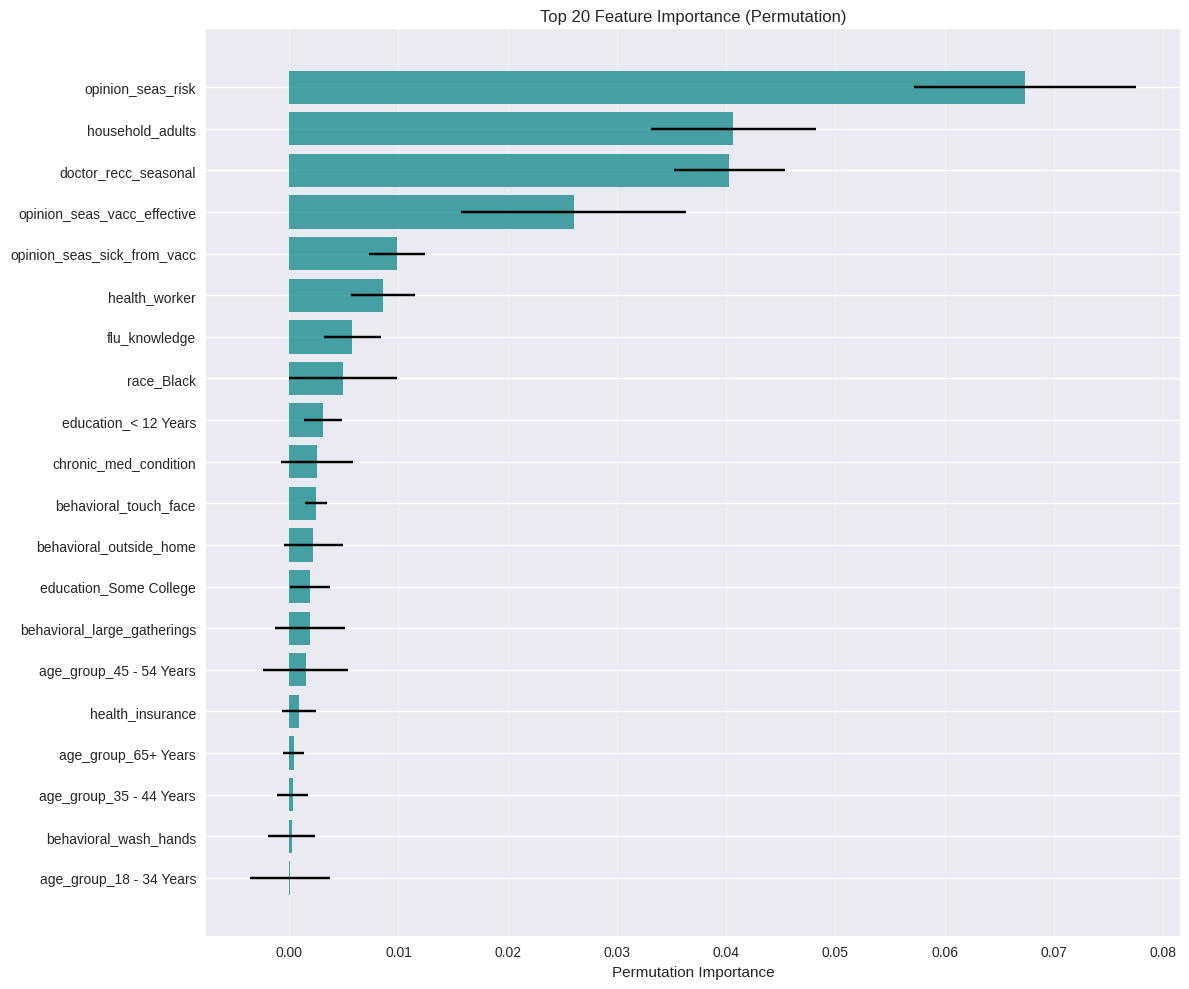

In [63]:
# ==============================
# 🔍 EXPLAINABLE AI (XAI) ANALYSIS
# ==============================

print("🔍 Performing Explainable AI (XAI) Analysis...")

# Create validation split for XAI (to avoid data leakage)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"📊 Training set: {X_train.shape}, Validation set: {X_val.shape}")

# Retrain best model on training split for XAI
print(f"\nRetraining {best_model_name} on training split...")
best_model.fit(X_train, y_train)

# 1. Permutation Importance
print("\n1.Permutation Feature Importance")

perm_importance = permutation_importance(
    best_model, X_val, y_val,
    n_repeats=5,
    random_state=SEED,
    scoring=PRIMARY_METRIC,
    n_jobs=-1
)

# Get feature names from preprocessor
preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['model']

# Extract feature names
numeric_features = numeric_columns
categorical_features = categorical_columns

# Get one-hot encoded feature names
if hasattr(preprocessor.named_transformers_['categorical'], 'named_steps'):
    ohe_encoder = preprocessor.named_transformers_['categorical'].named_steps['encoder']
    ohe_feature_names = ohe_encoder.get_feature_names_out(categorical_features)
else:
    ohe_encoder = preprocessor.named_transformers_['categorical']
    ohe_feature_names = ohe_encoder.get_feature_names_out(categorical_features)

all_feature_names = list(numeric_features) + list(ohe_feature_names)

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': all_feature_names[:len(perm_importance.importances_mean)],
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Top 20 Most Important Features:")
display(importance_df.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 10))
top_features = importance_df.head(20)
plt.barh(top_features['feature'], top_features['importance_mean'],
         xerr=top_features['importance_std'], alpha=0.7, color='teal')
plt.xlabel('Permutation Importance')
plt.title('Top 20 Feature Importance (Permutation)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


2.Partial Dependence Analysis
🔍 Creating partial dependence plots for top numeric features: ['opinion_seas_risk', 'household_adults', 'doctor_recc_seasonal']


<Figure size 1000x600 with 0 Axes>

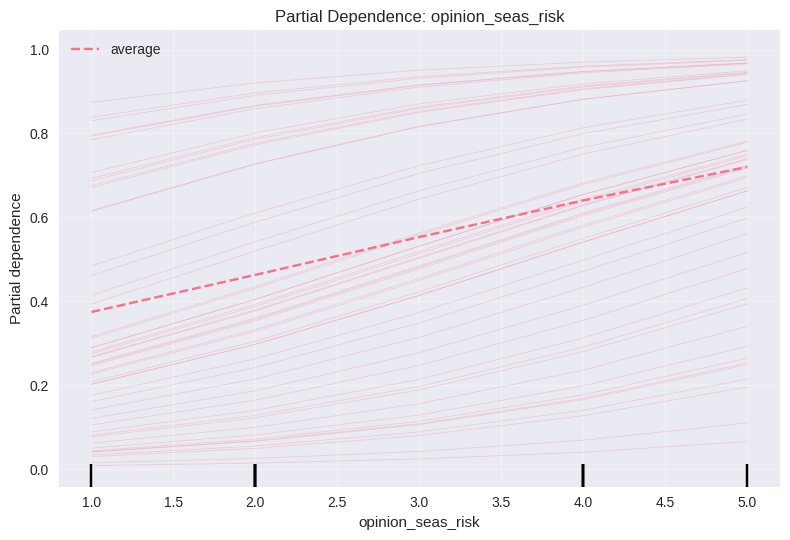

<Figure size 1000x600 with 0 Axes>

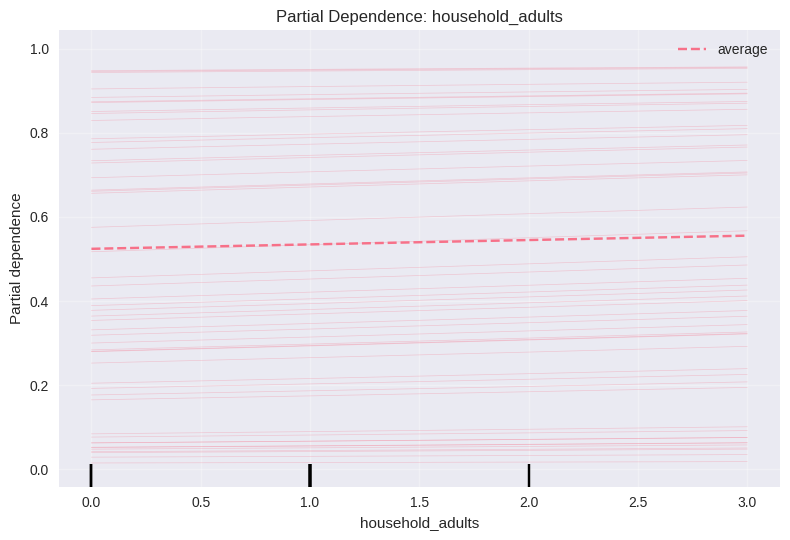

<Figure size 1000x600 with 0 Axes>

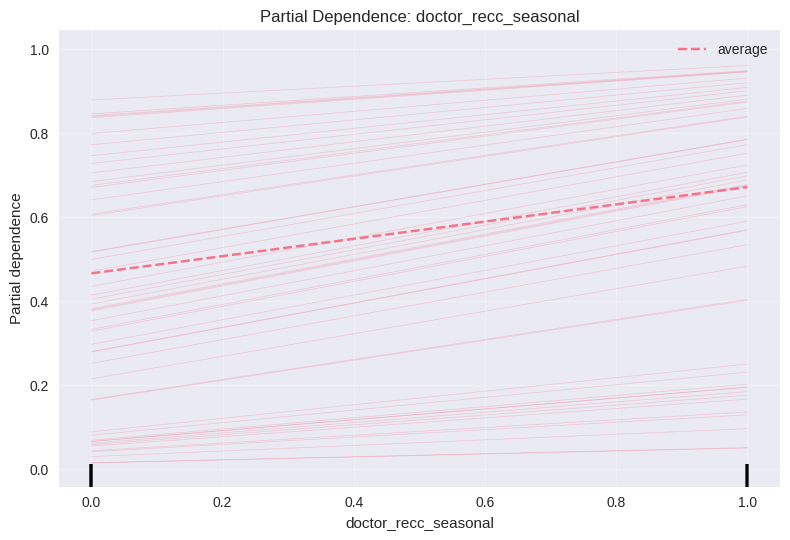


3.Model-Specific Feature Importance

✅ XAI analysis completed!


In [64]:
# 2. Partial Dependence Plots
print("\n2.Partial Dependence Analysis")

# Get top numeric features for PDP
top_numeric_features = [f for f in importance_df.head(10)['feature']
                       if f in numeric_features]

print(f"🔍 Creating partial dependence plots for top numeric features: {top_numeric_features[:3]}")

# Create partial dependence plots for top 3 numeric features
for feature in top_numeric_features[:3]:
    try:
        plt.figure(figsize=(10, 6))
        PartialDependenceDisplay.from_estimator(
            best_model, X_val, [feature],
            kind='both',  # Show both average and individual lines
            subsample=50,  # Use subset for faster computation
            random_state=SEED
        )
        plt.title(f'Partial Dependence: {feature}')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create PDP for {feature}: {e}")
        continue

# 3. Model-Specific Feature Importance
print("\n3.Model-Specific Feature Importance")

if hasattr(model, 'feature_importances_'):
    # For tree-based models
    model_importance = pd.DataFrame({
        'feature': all_feature_names[:len(model.feature_importances_)],
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Model-specific feature importance:")
    display(model_importance.head(10))

    # Visualize
    plt.figure(figsize=(12, 8))
    top_model_features = model_importance.head(15)
    plt.barh(top_model_features['feature'], top_model_features['importance'], color='orange', alpha=0.7)
    plt.xlabel('Feature Importance')
    plt.title('Model-Specific Feature Importance')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✅ XAI analysis completed!")

In [65]:
# ==============================
# SUBMISSION GENERATION
# ==============================

print("Submission Generation in the required format...")

GROUP_NUMBER = 9
N_SUBMISSIONS = min(5, len(results_df))
print(f"Creating {N_SUBMISSIONS} submission files for Group {GROUP_NUMBER}")

submission_files = []

for rank in range(N_SUBMISSIONS):
    model_info = results_df.iloc[rank]
    model_name = model_info['model']
    model_cv_score = model_info['best_cv_score']
    model = best_models[model_name]

    print(f"\n Preparing submission #{rank+1}: {model_name}")
    print(f"CV F1 Score: {model_cv_score:.4f}")

    # Retrain model on full dataset
    print("Retraining on full dataset...")
    model.fit(X, y)

    # Generate predictions
    test_predictions_proba = model.predict_proba(X_test)[:, 1]

    # Use optimal threshold for best model, 0.5 for others
    if rank == 0:  # Best model gets special treatment
        threshold = optimal_threshold['threshold']
        print(f"Using optimized threshold: {threshold:.3f}")
    else:
        threshold = 0.5
        print(f"Using default threshold: {threshold}")

    final_predictions = (test_predictions_proba >= threshold).astype(float)

    # Create submission dataframe
    submission_df = pd.DataFrame({
        "respondent_id": test_data[ID_COL].values,
        "seasonal_vaccine": final_predictions
    })

    filename = f"challenge_submission_group{GROUP_NUMBER}_order_{rank+1}.csv"
    submission_df.to_csv(filename, index=False)

    submission_files.append({
        'rank': rank + 1,
        'model': model_name,
        'cv_f1_score': float(model_cv_score),
        'filename': filename,
        'threshold_used': float(threshold)
    })

    print(f"✅ Saved: {filename}")
    print(f"File format: {filename} ✅ CORRECT NAMING")

    # Verify column names match exactly
    print(f"Column names: {list(submission_df.columns)}")

    # Show prediction distribution
    pred_counts = submission_df["seasonal_vaccine"].value_counts().sort_index()
    print(f"Prediction distribution: {dict(pred_counts)}")

print("\n" + "="*60)
print("SUBMISSION GENERATION COMPLETE!")
print("="*60)

# Display submission summary
submission_summary = pd.DataFrame(submission_files)
print("\nSubmission Files Summary:")
display(submission_summary)

#Verify file naming
print("\n VERIFYING SUBMISSION FILES:")
for submission in submission_files:
    filename = submission['filename']
    expected_pattern = f"challenge_submission_group{GROUP_NUMBER}_order_"
    if filename.startswith(expected_pattern):
        print(f"✅ {filename} - CORRECT FORMAT")
    else:
        print(f"❌ {filename} - WRONG FORMAT!")

# Save submission metadata
import json
metadata = {
    'submission_instructions': {
        'email_to': 'p.carrilho@herts.ac.uk',
        'deadline': '16:00 today',
        'files_to_submit': [s['filename'] for s in submission_files],
        'group_number': GROUP_NUMBER
    },
    'competition_info': {
        'target_variable': TARGET_COL,
        'primary_metric': PRIMARY_METRIC,
        'random_state': RANDOM_STATE
    },
    'best_model': {
        'name': best_model_name,
        'cv_f1_score': float(results_df.iloc[0]['best_cv_score']),
        'optimal_threshold': float(optimal_threshold['threshold'])
    },
    'submissions': submission_files
}

with open('submission_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("💾 Submission metadata saved to: submission_metadata.json")

# ⚠️ FINAL CHECKLIST FOR SUBMISSION
print("\n" + "="*60)
print("📋 FINAL SUBMISSION CHECKLIST")
print("="*60)
print(f"✅ Group Number: {GROUP_NUMBER}")
print(f"✅ Number of files: {N_SUBMISSIONS}")
print(f"✅ Files named as: challenge_submission_group{GROUP_NUMBER}_order_X.csv")
print(f"✅ Each file has columns: ['respondent_id', 'seasonal_vaccine']")
print(f"✅ All predictions are 0 or 1")
print(f"✅ Email to: p.carrilho@herts.ac.uk")

Submission Generation in the required format...
Creating 5 submission files for Group 9

 Preparing submission #1: Logistic_Regression
CV F1 Score: 0.7971
Retraining on full dataset...
Using optimized threshold: 0.443
✅ Saved: challenge_submission_group9_order_1.csv
File format: challenge_submission_group9_order_1.csv ✅ CORRECT NAMING
Column names: ['respondent_id', 'seasonal_vaccine']
Prediction distribution: {0.0: np.int64(1847), 1.0: np.int64(2902)}

 Preparing submission #2: XGBoost
CV F1 Score: 0.7969
Retraining on full dataset...
Using default threshold: 0.5
✅ Saved: challenge_submission_group9_order_2.csv
File format: challenge_submission_group9_order_2.csv ✅ CORRECT NAMING
Column names: ['respondent_id', 'seasonal_vaccine']
Prediction distribution: {0.0: np.int64(2033), 1.0: np.int64(2716)}

 Preparing submission #3: Gradient_Boosting
CV F1 Score: 0.7961
Retraining on full dataset...
Using default threshold: 0.5
✅ Saved: challenge_submission_group9_order_3.csv
File format: chal

,rank,model,cv_f1_score,filename,threshold_used
0,1,Logistic_Regression,0.797136,challenge_submission_group9_order_1.csv,0.442857
1,2,XGBoost,0.796928,challenge_submission_group9_order_2.csv,0.500000
2,3,Gradient_Boosting,0.796120,challenge_submission_group9_order_3.csv,0.500000
3,4,LightGBM,0.794971,challenge_submission_group9_order_4.csv,0.500000
4,5,HistGradient_Boosting,0.792745,challenge_submission_group9_order_5.csv,0.500000



 VERIFYING SUBMISSION FILES:
✅ challenge_submission_group9_order_1.csv - CORRECT FORMAT
✅ challenge_submission_group9_order_2.csv - CORRECT FORMAT
✅ challenge_submission_group9_order_3.csv - CORRECT FORMAT
✅ challenge_submission_group9_order_4.csv - CORRECT FORMAT
✅ challenge_submission_group9_order_5.csv - CORRECT FORMAT
💾 Submission metadata saved to: submission_metadata.json

📋 FINAL SUBMISSION CHECKLIST
✅ Group Number: 9
✅ Number of files: 5
✅ Files named as: challenge_submission_group9_order_X.csv
✅ Each file has columns: ['respondent_id', 'seasonal_vaccine']
✅ All predictions are 0 or 1
✅ Email to: p.carrilho@herts.ac.uk
